We use a grid of complex wavenumber values. From the generalized eigenvalue problem for a  given complex wavenumber, we obtain the phase speed, from which we substitute back to get the complex frequency. We then plot the contour of the imaginary part of the complex frequency. This is a test script to check the functionality of the code.


In [1]:
import os 
import sys
m_path = os.getcwd()
sys.path.append(m_path)

# import all required modules:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
#from mpmath import findroot
from scipy.linalg import lu, solve_triangular, eig
from numpy.linalg import cond

from stream_functions import StreamFunctions
from boundary_conditions import BoundaryConditions
from temporal_stability import TemporalStability
from two_equation_solver import *
from claude1 import *

Obtain the dispersion relation

In [ ]:

sf = StreamFunctions(n_wakes=2)
bc = BoundaryConditions(sf)
D  = bc.M_non_dim
A = bc.A_non_dim
B = bc.B_non_dim
#dispersion_relation = sp.simplify(sp.det(D))

KeyboardInterrupt: 

In [4]:
A_dim = bc.A
B_dim = bc.B
print(sp.latex(A_dim))
print(sp.latex(B_dim))

\left[\begin{matrix}1 & - e^{- 0.5 \alpha \delta} & 0 & 0 & - e^{0.5 \alpha \delta} & 0 & 0 & 0\\0 & e^{0.5 \alpha \delta} & - e^{- \alpha \left(0.5 D - 0.5 \delta\right)} & 0 & e^{- 0.5 \alpha \delta} & - e^{\alpha \left(0.5 D - 0.5 \delta\right)} & 0 & 0\\0 & 0 & e^{- \alpha \left(- 0.5 D + 0.5 \delta\right)} & - e^{- 0.5 \alpha \delta} & 0 & e^{\alpha \left(- 0.5 D + 0.5 \delta\right)} & - e^{0.5 \alpha \delta} & 0\\0 & 0 & 0 & e^{0.5 \alpha \delta} & 0 & 0 & e^{- 0.5 \alpha \delta} & - s e^{- \alpha \left(- 0.5 D + 0.5 L - 0.5 \delta\right)} - e^{\alpha \left(- 0.5 D + 0.5 L - 0.5 \delta\right)}\\- U_{ambient} \alpha \delta \rho_{ambient} & - \delta \left(- U_{ambient} \alpha \rho_{ambient} e^{- 0.5 \alpha \delta} - \frac{\rho_{ambient} \left(U_{ambient} - U_{wake}\right) e^{- 0.5 \alpha \delta}}{\delta}\right) & 0 & 0 & - \delta \left(U_{ambient} \alpha \rho_{ambient} e^{0.5 \alpha \delta} - \frac{\rho_{ambient} \left(U_{ambient} - U_{wake}\right) e^{0.5 \alpha \delta}}{\delta}\ri

In [5]:
print('A_non_dim')
print(sp.latex(A))
print('B_non_dim')
print(sp.latex(B))

A_non_dim
\left[\begin{matrix}1 & - e^{- 0.5 \alpha \delta} & 0 & 0 & - e^{0.5 \alpha \delta} & 0 & 0 & 0\\0 & e^{0.5 \alpha \delta} & - e^{- \alpha \left(0.5 - 0.5 \delta\right)} & 0 & e^{- 0.5 \alpha \delta} & - e^{\alpha \left(0.5 - 0.5 \delta\right)} & 0 & 0\\0 & 0 & e^{- \alpha \left(0.5 \delta - 0.5\right)} & - e^{- 0.5 \alpha \delta} & 0 & e^{\alpha \left(0.5 \delta - 0.5\right)} & - e^{0.5 \alpha \delta} & 0\\0 & 0 & 0 & e^{0.5 \alpha \delta} & 0 & 0 & e^{- 0.5 \alpha \delta} & - s e^{- \alpha \left(0.5 L - 0.5 \delta - 0.5\right)} - e^{\alpha \left(0.5 L - 0.5 \delta - 0.5\right)}\\- \alpha \delta \left(1 - \Lambda\right) & - \delta \left(\frac{2 \Lambda e^{- 0.5 \alpha \delta}}{\delta} - \alpha \left(1 - \Lambda\right) e^{- 0.5 \alpha \delta}\right) & 0 & 0 & - \delta \left(\frac{2 \Lambda e^{0.5 \alpha \delta}}{\delta} + \alpha \left(1 - \Lambda\right) e^{0.5 \alpha \delta}\right) & 0 & 0 & 0\\0 & \delta \left(\frac{2 \Lambda e^{0.5 \alpha \delta}}{\delta} - \alpha \left(\La

Substitute the desired values

In [8]:
#val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 's':-1, 'c': f'{sf.w}/{sf.alpha}'}
#val_set = {'S': 1.0, 'Lambda': -3.1, 'L': 0.0, 'delta': 0.1, 's':-1}
val_set = {'S': 0.2, 'Lambda': -3.1, 'L': 2.0, 'delta': 0.1, 's':-1}
#val_set = {'S': 1, 'Lambda': 0.9, 'L': 0.0, 'delta': 0.5, 's':-1}
A_sub = A.subs(val_set)
B_sub = B.subs(val_set)
D_sub = D.subs(val_set)
#dispersion_relation_sub = sp.det(D_sub)

Form the derivative of the determinant equals $0$ equation

In [9]:
#deriv_disp = sp.diff(dispersion_relation_sub, sf.alpha)
#print(sp.latex(deriv_disp))

Solve the generalized eigenvalue problem to obtain value for c for a grid of phase_speed $c$ values

In [10]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
alpha_r = np.arange(0,4.01,0.1)
alpha_i = np.arange(-4,4,0.1)
alpha_R, alpha_I = np.meshgrid(alpha_r, alpha_i)
alpha = alpha_R + 1j * alpha_I
w_vals_imag = np.zeros_like(alpha_I)
w_vals = np.zeros_like(alpha)

for i in range(alpha.shape[0]):
    print(f'Row {i+1} of {alpha.shape[0]}')
    for j in range(alpha.shape[1]):
        alpha_val = alpha[i,j]
        c_val_list = ts.find_c(alpha_val)
        temp_w_vals = c_val_list * alpha_val
        temp_w_vals[np.isnan(np.abs(temp_w_vals))] = -1e10-1j*1e10
        temp_w_vals[np.isinf(np.abs(temp_w_vals))] = -1e10-1j*1e10
        temp_w_vals[np.abs(temp_w_vals) > max_threshold] = -1e10-1j*1e10
        temp_w_vals = temp_w_vals[temp_w_vals != 0 + 0j]
        if len(temp_w_vals) == 0:
            temp_max_w_val_imag = np.array([0.0])
        else:
            temp_max_w_val_imag = np.max(np.imag(temp_w_vals)) 
        max_w_val_idx = np.argmax(np.imag(temp_w_vals))
        w_vals[i,j] = temp_w_vals[max_w_val_idx]
        w_vals_imag[i,j] = np.imag(w_vals[i,j])

Row 1 of 80


C:\Users\tvivek\AppData\Local\Temp\ipykernel_11016\2469909784.py:15: RuntimeWarning: invalid value encountered in multiply
  temp_w_vals = c_val_list * alpha_val


Row 2 of 80
Row 3 of 80
Row 4 of 80
Row 5 of 80
Row 6 of 80
Row 7 of 80
Row 8 of 80
Row 9 of 80
Row 10 of 80
Row 11 of 80
Row 12 of 80
Row 13 of 80
Row 14 of 80
Row 15 of 80
Row 16 of 80
Row 17 of 80
Row 18 of 80
Row 19 of 80
Row 20 of 80
Row 21 of 80
Row 22 of 80
Row 23 of 80
Row 24 of 80
Row 25 of 80
Row 26 of 80
Row 27 of 80
Row 28 of 80
Row 29 of 80
Row 30 of 80
Row 31 of 80
Row 32 of 80
Row 33 of 80
Row 34 of 80
Row 35 of 80
Row 36 of 80
Row 37 of 80
Row 38 of 80
Row 39 of 80
Row 40 of 80
Row 41 of 80
Row 42 of 80
Row 43 of 80
Row 44 of 80
Row 45 of 80
Row 46 of 80
Row 47 of 80
Row 48 of 80
Row 49 of 80
Row 50 of 80
Row 51 of 80
Row 52 of 80
Row 53 of 80
Row 54 of 80
Row 55 of 80
Row 56 of 80
Row 57 of 80
Row 58 of 80
Row 59 of 80
Row 60 of 80
Row 61 of 80
Row 62 of 80
Row 63 of 80
Row 64 of 80
Row 65 of 80
Row 66 of 80
Row 67 of 80
Row 68 of 80
Row 69 of 80
Row 70 of 80
Row 71 of 80
Row 72 of 80
Row 73 of 80
Row 74 of 80
Row 75 of 80
Row 76 of 80
Row 77 of 80
Row 78 of 80
Row 79 

Contour field plot of $\max(w_{i})$ on the complex frequency plane

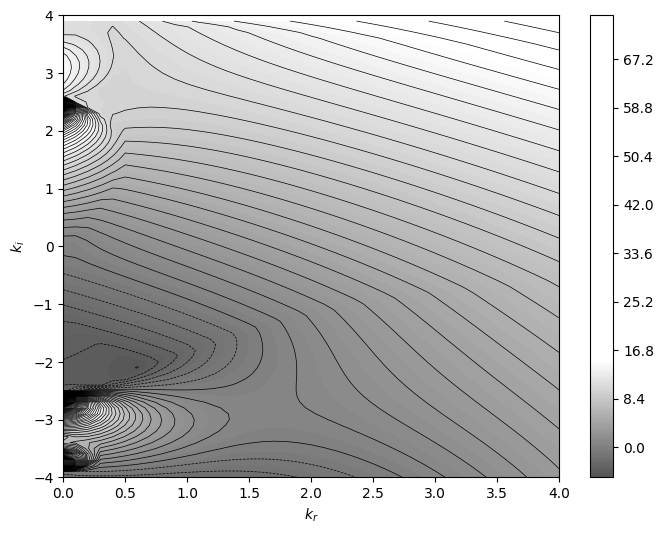

In [11]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(alpha_R, alpha_I, np.real(w_vals_imag), levels=250)
cbar = plt.colorbar(cs)
cs.set_clim(-15, 15)
ax.contour(alpha_R, alpha_I, np.real(w_vals_imag), levels=100, colors='black', linewidths=0.5)
# set colormap to jet
cs.set_cmap('gray')
ax.set_xlabel('$k_r$')
ax.set_ylabel('$k_i$')
ax.set_xlim(0, 4)
ax.set_ylim(-4, 4)
plt.ion()
plt.show()

Find the minimum absolute value of $\partial D/\partial k$:

In [160]:
print(w_vals_imag.shape)
print(alpha.shape)
deriv_vals = np.zeros_like(alpha)
deriv_val_set = {'c': f'{sf.w}/{sf.alpha}'}
deriv_disp_sub1 = deriv_disp.subs(deriv_val_set)
for i in range(alpha.shape[0]):
    print(f'Row {i+1} of {alpha.shape[0]}')
    for j in range(alpha.shape[1]):
        deriv_disp_sub2 = deriv_disp_sub1.subs({sf.alpha: alpha[i,j], sf.w: w_vals[i,j]})
        deriv_vals[i,j] = deriv_disp_sub2.evalf()

(80, 41)
(80, 41)
Row 1 of 80
Row 2 of 80
Row 3 of 80
Row 4 of 80
Row 5 of 80
Row 6 of 80
Row 7 of 80
Row 8 of 80
Row 9 of 80
Row 10 of 80
Row 11 of 80
Row 12 of 80
Row 13 of 80
Row 14 of 80
Row 15 of 80
Row 16 of 80
Row 17 of 80
Row 18 of 80
Row 19 of 80
Row 20 of 80
Row 21 of 80
Row 22 of 80
Row 23 of 80
Row 24 of 80
Row 25 of 80
Row 26 of 80
Row 27 of 80
Row 28 of 80
Row 29 of 80
Row 30 of 80
Row 31 of 80
Row 32 of 80
Row 33 of 80
Row 34 of 80
Row 35 of 80
Row 36 of 80
Row 37 of 80
Row 38 of 80
Row 39 of 80
Row 40 of 80
Row 41 of 80
Row 42 of 80
Row 43 of 80
Row 44 of 80
Row 45 of 80
Row 46 of 80
Row 47 of 80
Row 48 of 80
Row 49 of 80
Row 50 of 80
Row 51 of 80
Row 52 of 80


KeyboardInterrupt: 

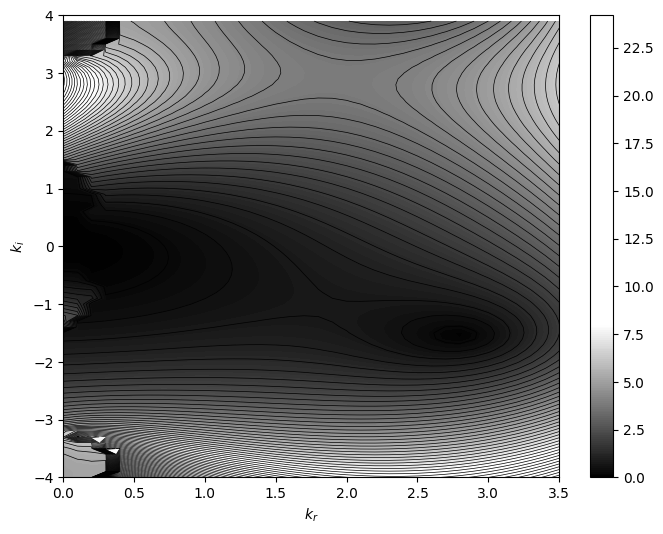

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(alpha_R, alpha_I, np.abs(deriv_vals), levels=250)
cbar = plt.colorbar(cs)
cs.set_clim(0, 8)
ax.contour(alpha_R, alpha_I, np.abs(deriv_vals), levels=100, colors='black', linewidths=0.5)
# set colormap to jet
cs.set_cmap('gray')
ax.set_xlabel('$k_r$')
ax.set_ylabel('$k_i$')
ax.set_xlim(0, 3.5)
ax.set_ylim(-4, 4)
plt.ion()
plt.show()

In [ ]:
res_i, res_j = np.unravel_index(np.argmin(np.abs(deriv_vals)), deriv_vals.shape)
print(f'{res_i}, {res_j}')
print(alpha_R[res_i, res_j])
print(alpha_I[res_i, res_j])
print(deriv_vals[res_i, res_j])
print(abs(deriv_vals[res_i, res_j]))

40, 0
0.0
3.552713678800501e-15
(3.727441658333934e-16-9.775367168668851e-17j)
3.8534918384636704e-16


In [ ]:
# save data as mat file
import scipy.io as sio
sio.savemat('C:\\Users\\tvivek\\Desktop\\w_vals_imag.mat', {'w_vals': w_vals, 'alpha_R': alpha_R, 'alpha_I': alpha_I})

In [ ]:
from matplotlib.widgets import Cursor
# Add cursor for better pointing
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

# Create annotation that will show the value
annot = ax.annotate("", xy=(0,0), xytext=(20,20), 
                   textcoords="offset points",
                   bbox=dict(boxstyle="round", fc="w"),
                   arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def onclick(event):
    if event.inaxes != ax:
        return
    
    # Hide previous annotation
    annot.set_visible(False)
    
    # Get clicked coordinates
    x_click, y_click = event.xdata, event.ydata
    
    # Find closest data point (since we can't interpolate from contour directly)
    idx_x = np.argmin(np.abs(x - x_click))
    idx_y = np.argmin(np.abs(y - y_click))
    z_value = Z[idx_y, idx_x]  # Note y comes first in 2D arrays
    
    # Update annotation
    annot.xy = (x_click, y_click)
    annot.set_text(f"Value: {z_value:.3f}")
    annot.set_visible(True)
    
    # Mark the clicked point
    if hasattr(onclick, 'marker'):
        onclick.marker.remove()
    onclick.marker = ax.plot(x_click, y_click, 'ro')[0]
    
    fig.canvas.draw_idle()

# Connect the click event
fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

The biggest problem that I'm facing right now is the uncertainty of not knowing whether the dispersion relation that I have is actually correct or wrong. That can be partially (I think 80%) rectified if I'm able to match the existing results of temporal stability from literature with the result that I'm getting with the dispersion relation that I derived. So here we do exactly that: 

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_8204\2256976604.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

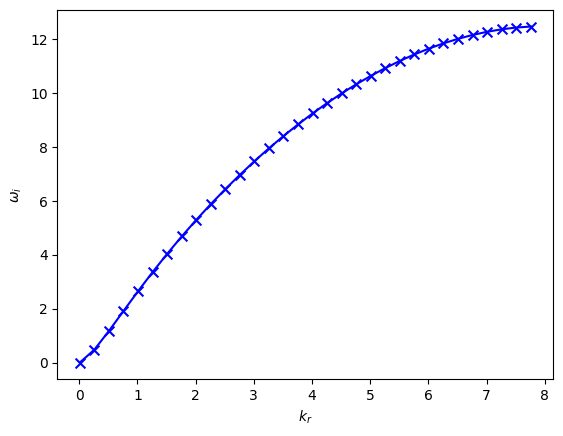

In [ ]:
alpha_r_ts = np.arange(0.01, 8.01, 0.25)
c_vals = []
for alpha_val in alpha_r_ts:
    c_val_list = ts.find_c(alpha_val)
    c_val_list[np.isinf(np.abs(c_val_list))] = -1000000000
    c_vals.append(np.max(np.imag(c_val_list)))

c_vals = np.array(c_vals)
w_vals = c_vals * alpha_r_ts

plt.ion()
plt.figure()
#plt.plot(x_D, w0i, color='blue', linestyle='--')
plt.plot(alpha_r_ts, w_vals, color='blue')
plt.scatter(alpha_r_ts, w_vals, color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

In [ ]:
c_val_list.shape

(4,)